In [95]:
pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html



In [93]:
pip install interpret

In [33]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [96]:
import statsmodels.api as sm

In [97]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

In [98]:
tic = time.time()

In [79]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [80]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


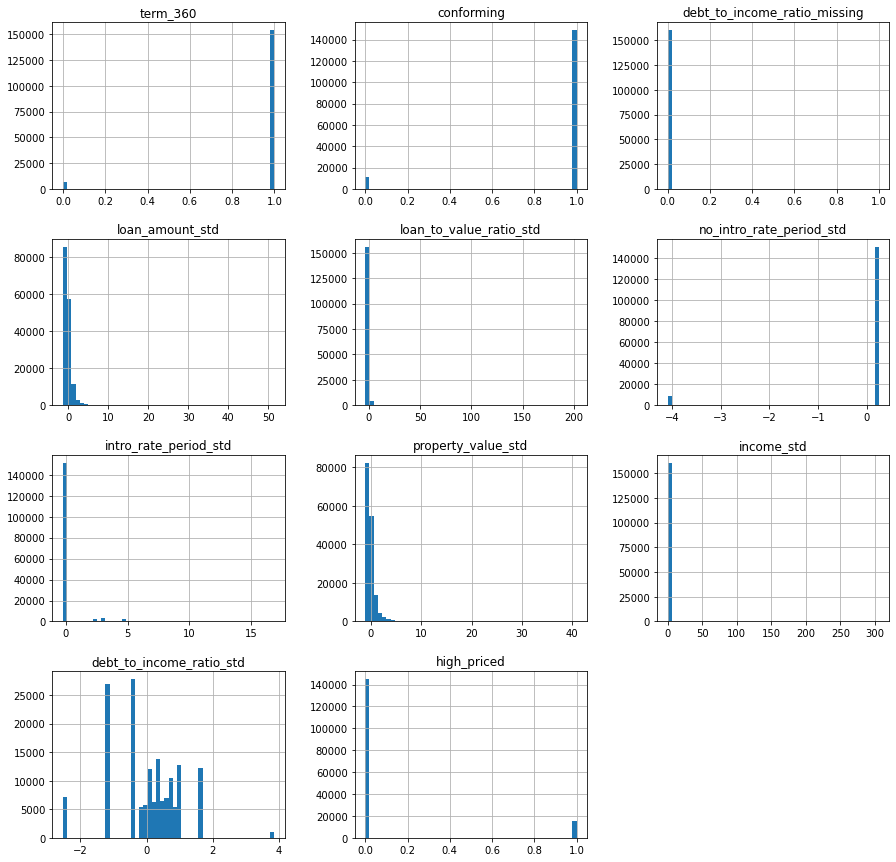

In [39]:
##Histogram
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

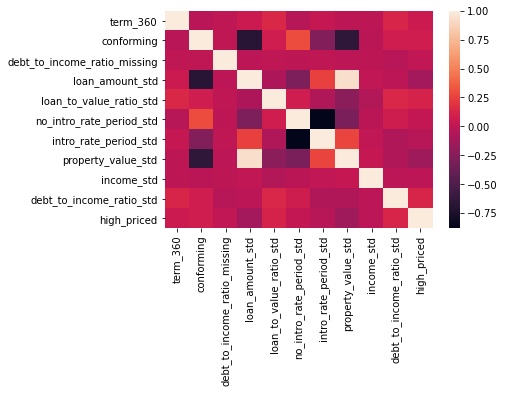

In [40]:
##Correlations
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

In [41]:
import random

In [42]:

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112290, columns = 23
Validation data rows = 48048, columns = 23


In [43]:
train.describe()

row_id         black         asian         white         amind  \
count  112290.000000  96458.000000  96458.000000  96458.000000  96458.000000   
mean    80218.322121      0.079154      0.079579      0.834094      0.004541   
std     46315.980108      0.269980      0.270641      0.371999      0.067233   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%     40118.250000      0.000000      0.000000      1.000000      0.000000   
50%     80403.500000      0.000000      0.000000      1.000000      0.000000   
75%    120382.750000      0.000000      0.000000      1.000000      0.000000   
max    160337.000000      1.000000      1.000000      1.000000      1.000000   

              hipac      hispanic  non_hispanic          male        female  \
count  96458.000000  96617.000000  96617.000000  60508.000000  60508.000000   
mean       0.002633      0.119482      0.880518      0.612498      0.387502   
std        0.051248      0.324357      0.324357      0.487184      0.487184   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      1.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      1.000000      0.000000   
75%        0.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...     conforming  debt_to_income_ratio_missing  loan_amount_std  \
count  ...  112290.000000                 112290.000000    112290.000000   
mean   ...       0.928694                      0.000641        -0.000770   
std    ...       0.257337                      0.025314         1.000178   
min    ...       0.000000                      0.000000        -1.261924   
25%    ...       1.000000                      0.000000        -0.558366   
50%    ...       1.000000                      0.000000        -0.250559   
75%    ...       1.000000                      0.000000         0.277109   
max    ...       1.000000                      1.000000        51.504926   

       loan_to_value_ratio_std  no_intro_rate_period_std  \
count            112290.000000             112290.000000   
mean                 -0.001946                  0.001889   
std                   0.941954                  0.996363   
min                  -3.479243                 -4.091747   
25%                  -0.277030                  0.244394   
50%                   0.179223                  0.244394   
75%                   0.428088                  0.244394   
max                 189.275099                  0.244394   

       intro_rate_period_std  property_value_std     income_std  \
count          112290.000000       112290.000000  112290.000000   
mean               -0.002689           -0.000235      -0.001667   
std                 0.989616            0.999111       1.079476   
min                -0.215304           -1.090958      -0.097823   
25%                -0.215304           -0.535932      -0.033378   
50%                -0.215304           -0.258419      -0.023676   
75%                -0.215304            0.173267      -0.007738   
max                14.263178           40.844338     305.542965   

       debt_to_income_ratio_std    high_priced  
count             112290.000000  112290.000000  
mean                  -0.001382       0.096269  
std                    1.000117       0.294961  
min                   -2.527547       0.000000  
25%                   -0.425131       0.000000  
50%                    0.123326       0.000000  
75%                    0.671782       0.000000  
max                    3.871110       1.000000  

[8 rows x 23 columns]

In [135]:
#Step1: Encode training Variables
variables = data.columns[12:22]
encode_df = pd.get_dummies(data[variables]) 
list(encode_df.columns)


['term_360',
 'conforming',
 'debt_to_income_ratio_missing',
 'loan_amount_std',
 'loan_to_value_ratio_std',
 'no_intro_rate_period_std',
 'intro_rate_period_std',
 'property_value_std',
 'income_std',
 'debt_to_income_ratio_std']

In [139]:
X = sm.add_constant(encode_df)
Y = data.high_priced

In [140]:
#Step2: Splitting into Train and Validation Sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)

In [141]:
#Step3: Building Logistic Regression Model using built X and Y
import statsmodels.api as sm
Logistic = sm.Logit(y_train, X_train)
Logistic = Logistic.fit()

Optimization terminated successfully.
         Current function value: 0.283114
         Iterations 11


In [142]:
##Print summary
print(Logistic.summary())

                           Logit Regression Results                           
Dep. Variable:            high_priced   No. Observations:               112236
Model:                          Logit   Df Residuals:                   112225
Method:                           MLE   Df Model:                           10
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.1116
Time:                        21:42:13   Log-Likelihood:                -31776.
converged:                       True   LL-Null:                       -35765.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -3.1249      0.139    -22.558      0.000      -3.396      -2.853
term_360                         1.0466      0.105      9.978      0.000     

In [24]:
#####Remove the variables that not significant

In [162]:
variablesNew = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std','debt_to_income_ratio_std']
encode_df1 = pd.get_dummies(data[variablesNew]) 

X = sm.add_constant(encode_df1)
Y = data.high_priced
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)
Logistic = sm.Logit(y_train, X_train)
Logistic = Logistic.fit()
print(Logistic.summary())

Optimization terminated successfully.
         Current function value: 0.283114
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            high_priced   No. Observations:               112236
Model:                          Logit   Df Residuals:                   112226
Method:                           MLE   Df Model:                            9
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.1116
Time:                        21:50:38   Log-Likelihood:                -31776.
converged:                       True   LL-Null:                       -35765.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -3.1248      0.139    -22.558      0.00

In [174]:
significant_vars = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std','debt_to_income_ratio_std']
#Step5 : Using the model that we create by train data to predict the test data
y_pred_df = pd.DataFrame( { "actual": y_test,"predicted_prob": Logistic.predict(sm.add_constant( X_test[significant_vars] ) ) } )

In [175]:
y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
y_pred_df.sample(9, random_state = 30)

actual  predicted_prob  predicted
109147       0        0.297276          0
8053         0        0.108669          0
53369        0        0.100842          0
69780        0        0.050319          0
125168       0        0.076674          0
158236       0        0.173692          0
58960        0        0.074076          0
108070       0        0.126906          0
81479        0        0.227753          0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


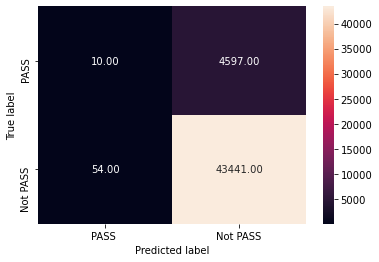

In [178]:
#Step6: Creating a Confusion Matrix by using our newly crreate table of predict and actual
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn import metrics
def draw_cm( actual, predicted ):
## Cret
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    sn.heatmap(cm, annot=True, fmt='.2f',
    xticklabels = ["PASS ", "Not PASS"] ,
    yticklabels = ["PASS", "Not PASS"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
draw_cm( y_pred_df.actual,y_pred_df.predicted )

In [179]:
print( metrics.classification_report( y_pred_df.actual,y_pred_df.predicted ) )

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     43495
           1       0.16      0.00      0.00      4607

    accuracy                           0.90     48102
   macro avg       0.53      0.50      0.48     48102
weighted avg       0.83      0.90      0.86     48102



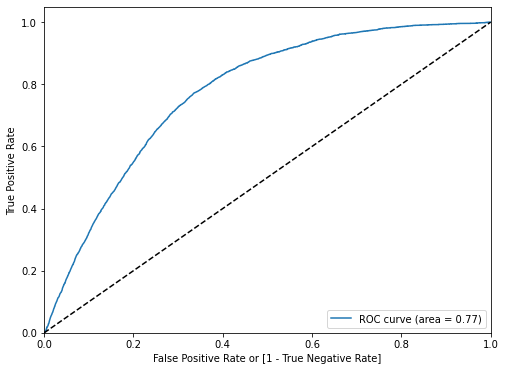

In [180]:
##Step7: drawing ROC & AUC
def draw_roc( actual, probs ):
    fpr, \
    tpr, \
    thresholds = metrics.roc_curve( actual,probs,drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(8, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

fpr, tpr, thresholds = draw_roc( y_pred_df.actual,y_pred_df.predicted_prob)


In [181]:
auc_score = metrics.roc_auc_score( y_pred_df.actual,y_pred_df.predicted_prob )
round( float( auc_score ), 2 )

0.77